In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

In [2]:
model = models.resnet18(pretrained=True)
model.eval();

/Users/alpayozkan/opt/anaconda3/envs/ex4/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alpayozkan/opt/anaconda3/envs/ex4/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/alpayozkan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.9MB/s]


# Check labels of class

In [3]:
import urllib
import ast

# The URL which has stored the categories of ImageNet
url_class = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'

# Load the classes and store them as a list
labels = []
for line in urllib.request.urlopen(url_class):
  txt = line.decode('utf-8')
  # Clean the string
  label = ''.join([i for i in txt if not i.isdigit() and i != ':' and i != ','])
  labels.append(label.strip())

print('We have', len(labels), 'classes')

# That's the Toucan label
true_label = 20
print(str(true_label) + '-th label is', labels[true_label])

We have 1000 classes
555-th label is 'fire engine fire truck'


# Our Classmaximization Method (with gaussian blur)

In [4]:
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])

In [5]:
class ClassMaxim(nn.Module):
    def __init__(self):
        super(ClassMaxim, self).__init__()
        self.x_c = nn.parameter.Parameter(torch.randn(1, 3, 224, 224))  
        self.clone = self.x_c.clone()

In [6]:
from torchvision.transforms.functional import gaussian_blur
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [7]:
clsmax = ClassMaxim()
clss = 736 # billard class

# hyperparameters
lamb = 0.1
lr = 32
sigma = 1
kern_size = 3
blur_frequency = 4

In [8]:
def gaussian_blur_channelwise(input_tensor, kernel_size, sigma):
    channels = 3
    blurred_channels = []
    for c in range(channels):
        blurred_channel = gaussian_blur(input_tensor[:, c:c+1, :, :], kernel_size=kernel_size, sigma=sigma)
        blurred_channels.append(blurred_channel)
    return torch.cat(blurred_channels, dim=1)

<Figure size 640x480 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


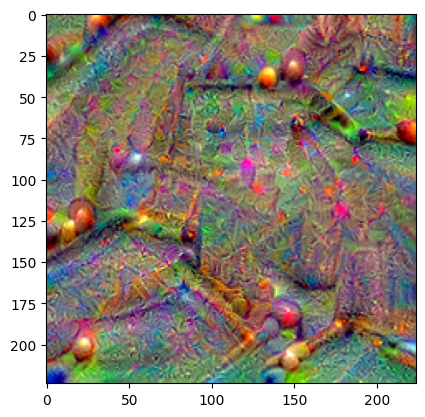

In [9]:
std_tens = torch.tensor(std).reshape(-1,1,1)
mean_tens = torch.tensor(mean).reshape(-1,1,1)

plt.figure()
for i in range(40):
    lr-=2
    if lr <= 8:
        lr = 8
    plt.imshow((clsmax.x_c[0]*std_tens + mean_tens).detach().numpy().transpose(1,2,0))
    plt.show()
    for step in range(20):
        xx = clsmax.x_c[0]
        preds = model(xx.unsqueeze(0)) # cnn 1 x 3 x 32 x 32, expected dim
        preds = preds.squeeze(0)

        loss = (preds[clss] - lamb*(torch.norm(clsmax.x_c[0],p=2)))
        (loss).backward()
        
        grad = clsmax.x_c.grad #/ (torch.norm(clsmax.x_c.grad)+ 1e-5) # l2 norm, grads
        clsmax.x_c = nn.Parameter(clsmax.x_c + grad*lr) # update step, gradient ascent

        with torch.no_grad():
            # normalize between 0 and 1
            min_value = torch.min(clsmax.x_c)
            max_value = torch.max(clsmax.x_c)
            normalized_tensor = (clsmax.x_c - min_value) / (max_value - min_value)
            blurred_tensor = normalized_tensor

            # Gaussian blur
            if step % blur_frequency == 0:
                blurred_tensor = gaussian_blur_channelwise(normalized_tensor, kernel_size=kern_size, sigma=sigma)
            
            # clipping pixels with small norm
            clipped_tensor = blurred_tensor
            norms = torch.norm(blurred_tensor, dim=1, p=2)
            below_threshold = norms < 0.001
            blurred_tensor[:, :, below_threshold.squeeze(0)] = 0
            clsmax.x_c = nn.Parameter(clipped_tensor  * (max_value - min_value) + min_value)
    
    if(i < 39):
        clear_output(wait=True)
        display(plt.gcf())
